In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Input, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

tf.get_logger().setLevel('ERROR')

# Innvestigate does not support eager execution
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

import innvestigate.utils as iutils
from innvestigate.analyzer.relevance_based.relevance_analyzer import LRPEpsilon

from pickle import load

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

In [2]:
scaler = load(open(f'Data_Step2/control/scaler.pkl', 'rb'))
scaler.mean_, scaler.scale_

(array([-2.85953411e-11,  3.68473248e+03, -2.93517822e-01, -1.78395655e-05,
         7.85527389e-05,  2.14230237e-03,  4.95123948e-07,  6.49555247e-07,
         3.01111445e+08, -1.45646523e+07]),
 array([1.86685043e-10, 1.61048766e+03, 7.99068436e-01, 1.03240757e-04,
        6.63678833e-01, 4.30530589e-02, 1.86624197e-05, 2.45397653e-06,
        1.35950753e+09, 9.36660921e+08]))

In [3]:
experiment = 'ssp585_2080_2099'

col_height = xr.open_dataset(f'Data_Step2/control/col_height.nc').rename({'yh':'lat', 'xh':'lon'})['col_height']
# Ensure that longitude coords are from -180 to 180
col_height.coords['lon'] = (col_height.coords['lon'] + 180) % 360 - 180
col_height = col_height.sortby(col_height.lon)

lat = col_height['lat']
lon = col_height['lon']

mom6_labels = xr.open_dataset(f'Data_Step2/control/mom6_labels_6_clusters.nc')['Label']
# Ensure that longitude coords are from -180 to 180
mom6_labels.coords['lon'] = (mom6_labels.coords['lon'] + 180) % 360 - 180
mom6_labels = mom6_labels.sortby(mom6_labels.lon)

In [4]:
num_clusters = 6

missingdataindex = np.load(f'Data_Step2/{experiment}/missingdataindex.npy')
maskTraining = np.load(f'Data_Step2/{experiment}/maskTraining.npy')
maskVal = np.load(f'Data_Step2/{experiment}/maskVal.npy')
maskTest = np.load(f'Data_Step2/{experiment}/maskTest.npy')

total_features = np.load(f'Data_Step2/{experiment}/total_features.npy')
train_features = np.load(f'Data_Step2/{experiment}/train_features.npy')
val_features = np.load(f'Data_Step2/{experiment}/val_features.npy')
test_features = np.load(f'Data_Step2/{experiment}/test_features.npy')

X_total_scaled = scaler.transform(total_features)
X_train_scaled = scaler.transform(train_features)
X_val_scaled = scaler.transform(val_features)
X_test_scaled = scaler.transform(test_features)

X_train_scaled.shape

(481049, 10)

In [5]:
# For running LRP on an ensemble of models
model_name = f'model_24x2_16x2_tanh_{num_clusters}_clusters'
total_pred = xr.open_dataset(f'Data_Step2/{experiment}/{model_name}_ensemble_mean_pred.nc')['Model Pred']
LRP_list = []

for i in range(50):
    tf.keras.backend.clear_session()
    model = None
    
    model = tf.keras.models.load_model(f'saved_models/{model_name}/model_{i}.h5')
    # LRP doesn't support softmax output, replace the last Dense layer's softmax
    # activation with simple linear activation
    model.layers[-1].activation = tf.keras.activations.linear
    
    LRP_analyzer = None
    LRP_analyzer = LRPEpsilon(model)
    analysisLRP = LRP_analyzer.analyze(X_total_scaled)
    LRP_list.append(analysisLRP)
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [6]:
LRP_concat = np.array(LRP_list)
LRP_concat.shape

(50, 834418, 10)

In [7]:
LRP_ensemble_scaled = LRP_concat/np.max(np.abs(LRP_concat), axis=2, keepdims=True)
LRP_ensemble_scaled.shape

(50, 834418, 10)

In [8]:
sizeflat = 1080,1440

In [9]:
def lrp_consist_subplot(var_name, var_idx, row, col):
    ensemble = LRP_ensemble_scaled[:,:,var_idx]
    
    ds_25 = np.zeros((sizeflat[0]*sizeflat[1]))
    ds_25[~missingdataindex.flatten()] = np.percentile(ensemble, 25, axis=0)
    
    ds_75 = np.zeros((sizeflat[0]*sizeflat[1]))
    ds_75[~missingdataindex.flatten()] = np.percentile(ensemble, 75, axis=0)
    
    LRP_consist_full = np.zeros((sizeflat[0]*sizeflat[1]))
    LRP_consist_full[ds_75 < 0] = ds_75[ds_75 < 0]
    LRP_consist_full[ds_25 > 0] = ds_25[ds_25 > 0]
    LRP_consist_full = LRP_consist_full.reshape(sizeflat)
    LRP_consist_full = xr.DataArray(data=LRP_consist_full,
                                    dims=['lat','lon'],
                                    coords=dict(lat=lat, lon=lon),
                                    name='LRP')
    LRP_consist_full = xr.where(~np.isnan(col_height), LRP_consist_full, np.nan)
    
    add_cbar = True
    if col != 4:
        add_cbar = False 
    LRP_consist_full.isel(lon=slice(400,800)).plot(ax=axes[row,col], transform=ccrs.PlateCarree(),
                                                   cmap='seismic', add_colorbar=add_cbar,
                                                   vmin=-1, vmax=1)
    axes[row,col].coastlines(resolution='10m')
    axes[row,col].add_feature(cfeature.LAND, facecolor='lightgrey')
    axes[row,col].set_title(var_name)
    
def lrp_consist_subplot_socean(var_name, var_idx, row, col):
    ensemble = LRP_ensemble_scaled[:,:,var_idx]
    
    ds_25 = np.zeros((sizeflat[0]*sizeflat[1]))
    ds_25[~missingdataindex.flatten()] = np.percentile(ensemble, 25, axis=0)
    
    ds_75 = np.zeros((sizeflat[0]*sizeflat[1]))
    ds_75[~missingdataindex.flatten()] = np.percentile(ensemble, 75, axis=0)
    
    LRP_consist_full = np.zeros((sizeflat[0]*sizeflat[1]))
    LRP_consist_full[ds_75 < 0] = ds_75[ds_75 < 0]
    LRP_consist_full[ds_25 > 0] = ds_25[ds_25 > 0]
    LRP_consist_full = LRP_consist_full.reshape(sizeflat)
    LRP_consist_full = xr.DataArray(data=LRP_consist_full,
                                    dims=['lat','lon'],
                                    coords=dict(lat=lat, lon=lon),
                                    name='LRP')
    LRP_consist_full = xr.where(~np.isnan(col_height), LRP_consist_full, np.nan)
    
    add_cbar = True
    if col != 4:
        add_cbar = False 
    LRP_consist_full.sel(lat=slice(-90,-40)).plot(ax=axes[row,col], transform=ccrs.PlateCarree(),
                                                  cmap='seismic', add_colorbar=add_cbar,
                                                  vmin=-1, vmax=1)
    axes[row,col].coastlines(resolution='10m')
    axes[row,col].add_feature(cfeature.LAND, facecolor='lightgrey')
    axes[row,col].set_title(var_name)
    
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    axes[row,col].set_boundary(circle, transform=axes[row,col].transAxes)

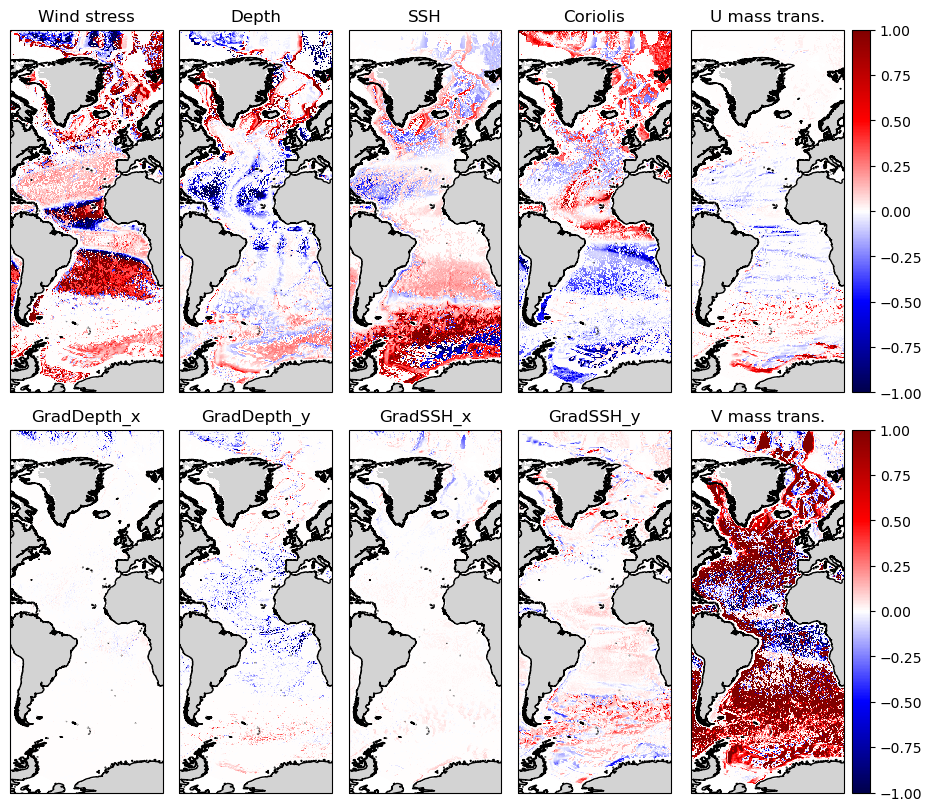

In [10]:
fig, axes = plt.subplots(2, 5, subplot_kw={'projection':ccrs.Miller()}, figsize=(9.25,8), constrained_layout=True)

lrp_consist_subplot('Wind stress', 0, 0, 0)
lrp_consist_subplot('Depth', 1, 0, 1)
lrp_consist_subplot('SSH', 2, 0, 2)
lrp_consist_subplot('Coriolis', 3, 0, 3)
lrp_consist_subplot('GradDepth_x', 4, 1, 0)
lrp_consist_subplot('GradDepth_y', 5, 1, 1)
lrp_consist_subplot('GradSSH_x', 6, 1, 2)
lrp_consist_subplot('GradSSH_y', 7, 1, 3)
lrp_consist_subplot('U mass trans.', 8, 0, 4)
lrp_consist_subplot('V mass trans.', 9, 1, 4)

#plt.savefig(f'figures/lrp/lrp_concise_atlantic_{experiment}.png', dpi=600)

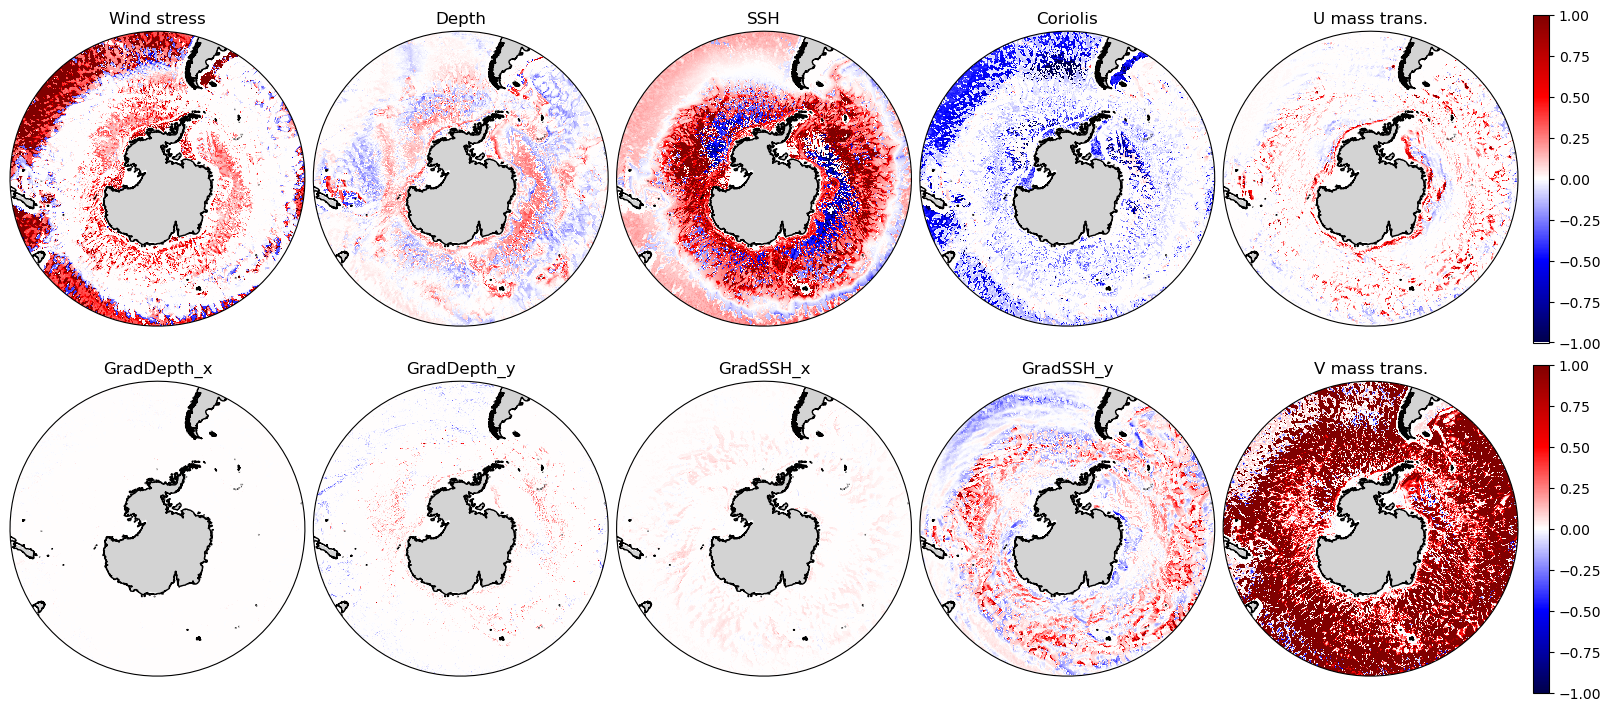

In [11]:
fig, axes = plt.subplots(2, 5, subplot_kw={'projection':ccrs.SouthPolarStereo(central_longitude=-90)}, figsize=(16,7), constrained_layout=True)

lrp_consist_subplot_socean('Wind stress', 0, 0, 0)
lrp_consist_subplot_socean('Depth', 1, 0, 1)
lrp_consist_subplot_socean('SSH', 2, 0, 2)
lrp_consist_subplot_socean('Coriolis', 3, 0, 3)
lrp_consist_subplot_socean('GradDepth_x', 4, 1, 0)
lrp_consist_subplot_socean('GradDepth_y', 5, 1, 1)
lrp_consist_subplot_socean('GradSSH_x', 6, 1, 2)
lrp_consist_subplot_socean('GradSSH_y', 7, 1, 3)
lrp_consist_subplot_socean('U mass trans.', 8, 0, 4)
lrp_consist_subplot_socean('V mass trans.', 9, 1, 4)

#plt.savefig(f'figures/lrp/lrp_concise_socean_{experiment}.png', dpi=600)

In [12]:
def lrp_plot_by_regime(save_path=None):
    fig, axes = plt.subplots(12, num_clusters, subplot_kw={'projection':ccrs.Miller()}, figsize=(12,18), constrained_layout=True)
    
    for regime in range(num_clusters):
        # Plot the isolated regime
        regime_mask = xr.where(total_pred == regime, total_pred, np.nan)
        to_plot = regime_mask.sel(lon=slice(-80,10)).sel(lat=slice(10,70))
        to_plot.plot(ax=axes[0,regime], transform=ccrs.PlateCarree(),
                     cmap=ListedColormap(plt.get_cmap('tab20', num_clusters).colors[regime]),
                     add_colorbar=False, vmin=-1, vmax=1)
        axes[0,regime].set_title(f'Regime {regime}')
            
        # Plot the true-false values for the regime
        tf = xr.where(total_pred == mom6_labels, 1, 0)
        tf_masked = xr.where(total_pred == regime, tf, np.nan)
        tf_masked.sel(lon=slice(-80,10)).sel(lat=slice(10,70)).plot(ax=axes[1,regime], transform=ccrs.PlateCarree(),
                                                                    cmap=ListedColormap(['purple', 'green']),
                                                                    add_colorbar=False, vmin=0, vmax=1)
    
    for var_idx in range(10):
        
        # Get the LRP values for an input variable
        ensemble = LRP_ensemble_scaled[:,:,var_idx]
    
        ds_25 = np.zeros((sizeflat[0]*sizeflat[1]))
        ds_25[~missingdataindex.flatten()] = np.percentile(ensemble, 25, axis=0)

        ds_75 = np.zeros((sizeflat[0]*sizeflat[1]))
        ds_75[~missingdataindex.flatten()] = np.percentile(ensemble, 75, axis=0)

        LRP_consist_full = np.zeros((sizeflat[0]*sizeflat[1]))
        LRP_consist_full[ds_75 < 0] = ds_75[ds_75 < 0]
        LRP_consist_full[ds_25 > 0] = ds_25[ds_25 > 0]
        LRP_consist_full = LRP_consist_full.reshape(sizeflat)
        LRP_consist_full = xr.DataArray(data=LRP_consist_full,
                                        dims=['lat','lon'],
                                        coords=dict(lat=col_height['lat'], lon=col_height['lon']),
                                        name='LRP')
        
        for regime in range(num_clusters):
            
            # Plot the LRP values for the regime
            LRP_consist_full_masked = xr.where(total_pred == regime, LRP_consist_full, np.nan)
            to_plot = LRP_consist_full_masked.sel(lon=slice(-80,10)).sel(lat=slice(10,70))
            to_plot.plot(ax=axes[var_idx+2,regime], transform=ccrs.PlateCarree(), cmap='seismic',
                         add_colorbar=False, vmin=-1, vmax=1)
            
    axes[0,0].set_ylabel('Mask')
    axes[1,0].set_ylabel('True-False')
    
    feature_names = ['curlTau', 'col_height', 'zos', 'f', 'gradColHeight_x',
                     'gradColHeight_y', 'gradZos_x', 'gradZos_y', 'umo_2d', 'vmo_2d']
    
    for i in range(len(feature_names)):
        axes[i+2,0].set_ylabel(feature_names[i])
        
    for i in range(12):
        for j in range(num_clusters):
            axes[i,j].set_yticks([])
            if j != 0:
                axes[i,j].set_ylabel('')
            axes[i,j].add_feature(cfeature.LAND, facecolor='lightgrey')
            axes[i,j].coastlines(resolution='10m')
    
    if save_path != None:
        plt.savefig(save_path, dpi=600)
    plt.show()
    
def lrp_plot_by_regime_scenario(save_path=None):
    fig, axes = plt.subplots(11, num_clusters, subplot_kw={'projection':ccrs.Miller()}, figsize=(12,18), constrained_layout=True)
    
    for regime in range(num_clusters):
        # Plot the isolated regime
        regime_mask = xr.where(total_pred == regime, total_pred, np.nan)
        to_plot = regime_mask.sel(lon=slice(-80,10)).sel(lat=slice(10,70))
        to_plot.plot(ax=axes[0,regime], transform=ccrs.PlateCarree(),
                     cmap=ListedColormap(plt.get_cmap('tab20', num_clusters).colors[regime]),
                     add_colorbar=False, vmin=-1, vmax=1)
        axes[0,regime].set_title(f'Regime {regime}')
    
    for var_idx in range(10):
        
        # Get the LRP values for an input variable
        ensemble = LRP_ensemble_scaled[:,:,var_idx]
    
        ds_25 = np.zeros((sizeflat[0]*sizeflat[1]))
        ds_25[~missingdataindex.flatten()] = np.percentile(ensemble, 25, axis=0)

        ds_75 = np.zeros((sizeflat[0]*sizeflat[1]))
        ds_75[~missingdataindex.flatten()] = np.percentile(ensemble, 75, axis=0)

        LRP_consist_full = np.zeros((sizeflat[0]*sizeflat[1]))
        LRP_consist_full[ds_75 < 0] = ds_75[ds_75 < 0]
        LRP_consist_full[ds_25 > 0] = ds_25[ds_25 > 0]
        LRP_consist_full = LRP_consist_full.reshape(sizeflat)
        LRP_consist_full = xr.DataArray(data=LRP_consist_full,
                                        dims=['lat','lon'],
                                        coords=dict(lat=col_height['lat'], lon=col_height['lon']),
                                        name='LRP')
        
        for regime in range(num_clusters):
            
            # Plot the LRP values for the regime
            LRP_consist_full_masked = xr.where(total_pred == regime, LRP_consist_full, np.nan)
            to_plot = LRP_consist_full_masked.sel(lon=slice(-80,10)).sel(lat=slice(10,70))
            to_plot.plot(ax=axes[var_idx+1,regime], transform=ccrs.PlateCarree(), cmap='seismic',
                         add_colorbar=False, vmin=-1, vmax=1)
            
    axes[0,0].set_ylabel('Mask')
    
    feature_names = ['curlTau', 'col_height', 'zos', 'f', 'gradColHeight_x',
                     'gradColHeight_y', 'gradZos_x', 'gradZos_y', 'umo_2d', 'vmo_2d']
    
    for i in range(len(feature_names)):
        axes[i+1,0].set_ylabel(feature_names[i])
        
    for i in range(11):
        for j in range(num_clusters):
            axes[i,j].set_yticks([])
            if j != 0:
                axes[i,j].set_ylabel('')
            axes[i,j].add_feature(cfeature.LAND, facecolor='lightgrey')
            axes[i,j].coastlines(resolution='10m')
    
    if save_path != None:
        plt.savefig(save_path, dpi=600)
    plt.show()

In [19]:
def lrp_plot_by_regime_socean(save_path=None):
    fig, axes = plt.subplots(12, num_clusters, subplot_kw={'projection':ccrs.Miller()}, figsize=(12,18), constrained_layout=True)
    
    for regime in range(num_clusters):
        # Plot the isolated regime
        regime_mask = xr.where(total_pred == regime, total_pred, np.nan)
        to_plot = regime_mask.sel(lon=slice(-80,10)).sel(lat=slice(-80,-40))
        to_plot.plot(ax=axes[0,regime], transform=ccrs.PlateCarree(),
                     cmap=ListedColormap(plt.get_cmap('tab20', num_clusters).colors[regime]),
                     add_colorbar=False, vmin=0, vmax=1)
        axes[0,regime].set_title(f'Regime {regime}')
            
        # Plot the true-false values for the regime
        tf = xr.where(total_pred == mom6_labels, 1, 0)
        tf_masked = xr.where(total_pred == regime, tf, np.nan)
        tf_masked.sel(lon=slice(-80,10)).sel(lat=slice(-80,-40)).plot(ax=axes[1,regime], transform=ccrs.PlateCarree(),
                                                                    cmap=ListedColormap(['purple', 'green']),
                                                                    add_colorbar=False, vmin=0, vmax=1)
    
    for var_idx in range(10):
        
        # Get the LRP values for an input variable
        ensemble = LRP_ensemble_scaled[:,:,var_idx]
    
        ds_25 = np.zeros((sizeflat[0]*sizeflat[1]))
        ds_25[~missingdataindex.flatten()] = np.percentile(ensemble, 25, axis=0)

        ds_75 = np.zeros((sizeflat[0]*sizeflat[1]))
        ds_75[~missingdataindex.flatten()] = np.percentile(ensemble, 75, axis=0)

        LRP_consist_full = np.zeros((sizeflat[0]*sizeflat[1]))
        LRP_consist_full[ds_75 < 0] = ds_75[ds_75 < 0]
        LRP_consist_full[ds_25 > 0] = ds_25[ds_25 > 0]
        LRP_consist_full = LRP_consist_full.reshape(sizeflat)
        LRP_consist_full = xr.DataArray(data=LRP_consist_full,
                                        dims=['lat','lon'],
                                        coords=dict(lat=col_height['lat'], lon=col_height['lon']),
                                        name='LRP')
        
        for regime in range(num_clusters):
            
            # Plot the LRP values for the regime
            LRP_consist_full_masked = xr.where(total_pred == regime, LRP_consist_full, np.nan)
            to_plot = LRP_consist_full_masked.sel(lon=slice(-80,10)).sel(lat=slice(-80,-40))
            to_plot.plot(ax=axes[var_idx+2,regime], transform=ccrs.PlateCarree(), cmap='seismic',
                         add_colorbar=False, vmin=-1, vmax=1)
            
    axes[0,0].set_ylabel('Mask')
    axes[1,0].set_ylabel('True-False')
    
    feature_names = ['curlTau', 'col_height', 'zos', 'f', 'gradColHeight_x',
                     'gradColHeight_y', 'gradZos_x', 'gradZos_y', 'umo_2d', 'vmo_2d']
    
    for i in range(len(feature_names)):
        axes[i+2,0].set_ylabel(feature_names[i])
        
    for i in range(12):
        for j in range(num_clusters):
            axes[i,j].set_yticks([])
            if j != 0:
                axes[i,j].set_ylabel('')
            axes[i,j].add_feature(cfeature.LAND, facecolor='lightgrey')
            axes[i,j].coastlines(resolution='10m')
            
    if save_path != None:
        plt.savefig(save_path, dpi=600)
    plt.show()

def lrp_plot_by_regime_socean_scenario(save_path=None):
    fig, axes = plt.subplots(11, num_clusters, subplot_kw={'projection':ccrs.Miller()}, figsize=(12,18), constrained_layout=True)
    
    for regime in range(num_clusters):
        # Plot the isolated regime
        regime_mask = xr.where(total_pred == regime, total_pred, np.nan)
        to_plot = regime_mask.sel(lon=slice(-80,10)).sel(lat=slice(-80,-40))
        to_plot.plot(ax=axes[0,regime], transform=ccrs.PlateCarree(),
                     cmap=ListedColormap(plt.get_cmap('tab20', num_clusters).colors[regime]),
                     add_colorbar=False, vmin=0, vmax=1)
        axes[0,regime].set_title(f'Regime {regime}')
    
    for var_idx in range(10):
        
        # Get the LRP values for an input variable
        ensemble = LRP_ensemble_scaled[:,:,var_idx]
    
        ds_25 = np.zeros((sizeflat[0]*sizeflat[1]))
        ds_25[~missingdataindex.flatten()] = np.percentile(ensemble, 25, axis=0)

        ds_75 = np.zeros((sizeflat[0]*sizeflat[1]))
        ds_75[~missingdataindex.flatten()] = np.percentile(ensemble, 75, axis=0)

        LRP_consist_full = np.zeros((sizeflat[0]*sizeflat[1]))
        LRP_consist_full[ds_75 < 0] = ds_75[ds_75 < 0]
        LRP_consist_full[ds_25 > 0] = ds_25[ds_25 > 0]
        LRP_consist_full = LRP_consist_full.reshape(sizeflat)
        LRP_consist_full = xr.DataArray(data=LRP_consist_full,
                                        dims=['lat','lon'],
                                        coords=dict(lat=col_height['lat'], lon=col_height['lon']),
                                        name='LRP')
        
        for regime in range(num_clusters):
            
            # Plot the LRP values for the regime
            LRP_consist_full_masked = xr.where(total_pred == regime, LRP_consist_full, np.nan)
            to_plot = LRP_consist_full_masked.sel(lon=slice(-80,10)).sel(lat=slice(-80,-40))
            to_plot.plot(ax=axes[var_idx+1,regime], transform=ccrs.PlateCarree(), cmap='seismic',
                         add_colorbar=False, vmin=-1, vmax=1)
            
    axes[0,0].set_ylabel('Mask')
    
    feature_names = ['curlTau', 'col_height', 'zos', 'f', 'gradColHeight_x',
                     'gradColHeight_y', 'gradZos_x', 'gradZos_y', 'umo_2d', 'vmo_2d']
    
    for i in range(len(feature_names)):
        axes[i+1,0].set_ylabel(feature_names[i])
        
    for i in range(11):
        for j in range(num_clusters):
            axes[i,j].set_yticks([])
            if j != 0:
                axes[i,j].set_ylabel('')
            axes[i,j].add_feature(cfeature.LAND, facecolor='lightgrey')
            axes[i,j].coastlines(resolution='10m')
            
    if save_path != None:
        plt.savefig(save_path, dpi=600)
    plt.show()
    
def lrp_plot_by_regime_socean_full(save_path=None):
    fig, axes = plt.subplots(12, num_clusters, subplot_kw={'projection':ccrs.SouthPolarStereo(central_longitude=-90)}, figsize=(12,24), constrained_layout=True)
    
    for regime in range(num_clusters):
        # Plot the isolated regime
        regime_mask = xr.where(total_pred == regime, total_pred, np.nan)
        to_plot = regime_mask.sel(lat=slice(-90,-40))
        to_plot.plot(ax=axes[0,regime], transform=ccrs.PlateCarree(),
                     cmap=ListedColormap(plt.get_cmap('tab20', num_clusters).colors[regime]),
                     add_colorbar=False, vmin=0, vmax=1)
        axes[0,regime].set_title(f'Regime {regime}')
        
        # Plot the true-false values for the regime
        tf = xr.where(total_pred == mom6_labels, 1, 0)
        tf_masked = xr.where(total_pred == regime, tf, np.nan)
        tf_masked.sel(lat=slice(-90,-40)).plot(ax=axes[1,regime], transform=ccrs.PlateCarree(),
                                               cmap=ListedColormap(['purple', 'green']),
                                               add_colorbar=False, vmin=0, vmax=1)
    
    for var_idx in range(10):
        
        # Get the LRP values for an input variable
        ensemble = LRP_ensemble_scaled[:,:,var_idx]
    
        ds_25 = np.zeros((sizeflat[0]*sizeflat[1]))
        ds_25[~missingdataindex.flatten()] = np.percentile(ensemble, 25, axis=0)

        ds_75 = np.zeros((sizeflat[0]*sizeflat[1]))
        ds_75[~missingdataindex.flatten()] = np.percentile(ensemble, 75, axis=0)

        LRP_consist_full = np.zeros((sizeflat[0]*sizeflat[1]))
        LRP_consist_full[ds_75 < 0] = ds_75[ds_75 < 0]
        LRP_consist_full[ds_25 > 0] = ds_25[ds_25 > 0]
        LRP_consist_full = LRP_consist_full.reshape(sizeflat)
        LRP_consist_full = xr.DataArray(data=LRP_consist_full,
                                        dims=['lat','lon'],
                                        coords=dict(lat=col_height['lat'], lon=col_height['lon']),
                                        name='LRP')
        
        for regime in range(num_clusters):
            
            # Plot the LRP values for the regime
            LRP_consist_full_masked = xr.where(total_pred == regime, LRP_consist_full, np.nan)
            to_plot = LRP_consist_full_masked.sel(lat=slice(-90,-40))
            to_plot.plot(ax=axes[var_idx+2,regime], transform=ccrs.PlateCarree(), cmap='seismic',
                         add_colorbar=False, vmin=-1, vmax=1)
            
    axes[0,0].set_ylabel('Mask')
    axes[1,0].set_ylabel('True-False')
    
    feature_names = ['curlTau', 'col_height', 'zos', 'f', 'gradColHeight_x',
                     'gradColHeight_y', 'gradZos_x', 'gradZos_y', 'umo_2d', 'vmo_2d']
    
    for i in range(len(feature_names)):
        axes[i+2,0].set_ylabel(feature_names[i])
        
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    for i in range(12):
        for j in range(num_clusters):
            axes[i,j].set_yticks([])
            if j != 0:
                axes[i,j].set_ylabel('')
            axes[i,j].add_feature(cfeature.LAND, facecolor='lightgrey')
            axes[i,j].coastlines(resolution='10m')
            axes[i,j].set_boundary(circle, transform=axes[i,j].transAxes)
            
    if save_path != None:
        plt.savefig(save_path, dpi=600)
    plt.show()
    
def lrp_plot_by_regime_socean_full_scenario(save_path=None):
    fig, axes = plt.subplots(11, num_clusters, subplot_kw={'projection':ccrs.SouthPolarStereo(central_longitude=-90)}, figsize=(11,24), constrained_layout=True)
    
    for regime in range(num_clusters):
        # Plot the isolated regime
        regime_mask = xr.where(total_pred == regime, total_pred, np.nan)
        to_plot = regime_mask.sel(lat=slice(-90,-40))
        to_plot.plot(ax=axes[0,regime], transform=ccrs.PlateCarree(),
                     cmap=ListedColormap(plt.get_cmap('tab20', num_clusters).colors[regime]),
                     add_colorbar=False, vmin=0, vmax=1)
        axes[0,regime].set_title(f'Regime {regime}')
    
    for var_idx in range(10):
        
        # Get the LRP values for an input variable
        ensemble = LRP_ensemble_scaled[:,:,var_idx]
    
        ds_25 = np.zeros((sizeflat[0]*sizeflat[1]))
        ds_25[~missingdataindex.flatten()] = np.percentile(ensemble, 25, axis=0)

        ds_75 = np.zeros((sizeflat[0]*sizeflat[1]))
        ds_75[~missingdataindex.flatten()] = np.percentile(ensemble, 75, axis=0)

        LRP_consist_full = np.zeros((sizeflat[0]*sizeflat[1]))
        LRP_consist_full[ds_75 < 0] = ds_75[ds_75 < 0]
        LRP_consist_full[ds_25 > 0] = ds_25[ds_25 > 0]
        LRP_consist_full = LRP_consist_full.reshape(sizeflat)
        LRP_consist_full = xr.DataArray(data=LRP_consist_full,
                                        dims=['lat','lon'],
                                        coords=dict(lat=col_height['lat'], lon=col_height['lon']),
                                        name='LRP')
            
        for regime in range(num_clusters):
            
            # Plot the LRP values for the regime
            LRP_consist_full_masked = xr.where(total_pred == regime, LRP_consist_full, np.nan)
            to_plot = LRP_consist_full_masked.sel(lat=slice(-90,-40))
            
            if var_idx == 9:
                to_plot.plot(ax=axes[var_idx+1,regime], transform=ccrs.PlateCarree(), cmap='seismic',
                             add_colorbar=True, vmin=-1, vmax=1, cbar_kwargs={'label':'', 'orientation':'horizontal'})
            else:
                to_plot.plot(ax=axes[var_idx+1,regime], transform=ccrs.PlateCarree(), cmap='seismic',
                             add_colorbar=False, vmin=-1, vmax=1)
            
    axes[0,0].set_ylabel('Expanse')
    
    feature_names = ['curlTau', 'col_height', 'zos', 'f', 'gradColHeight_x',
                     'gradColHeight_y', 'gradZos_x', 'gradZos_y', 'umo_2d', 'vmo_2d']
    
    for i in range(len(feature_names)):
        axes[i+1,0].set_ylabel(feature_names[i])
        
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    for i in range(11):
        for j in range(num_clusters):
            axes[i,j].set_yticks([])
            if j != 0:
                axes[i,j].set_ylabel('')
            axes[i,j].add_feature(cfeature.LAND, facecolor='lightgrey')
            axes[i,j].coastlines(resolution='10m')
            axes[i,j].set_boundary(circle, transform=axes[i,j].transAxes)
            
    if save_path != None:
        plt.savefig(save_path, dpi=600)
    plt.show()

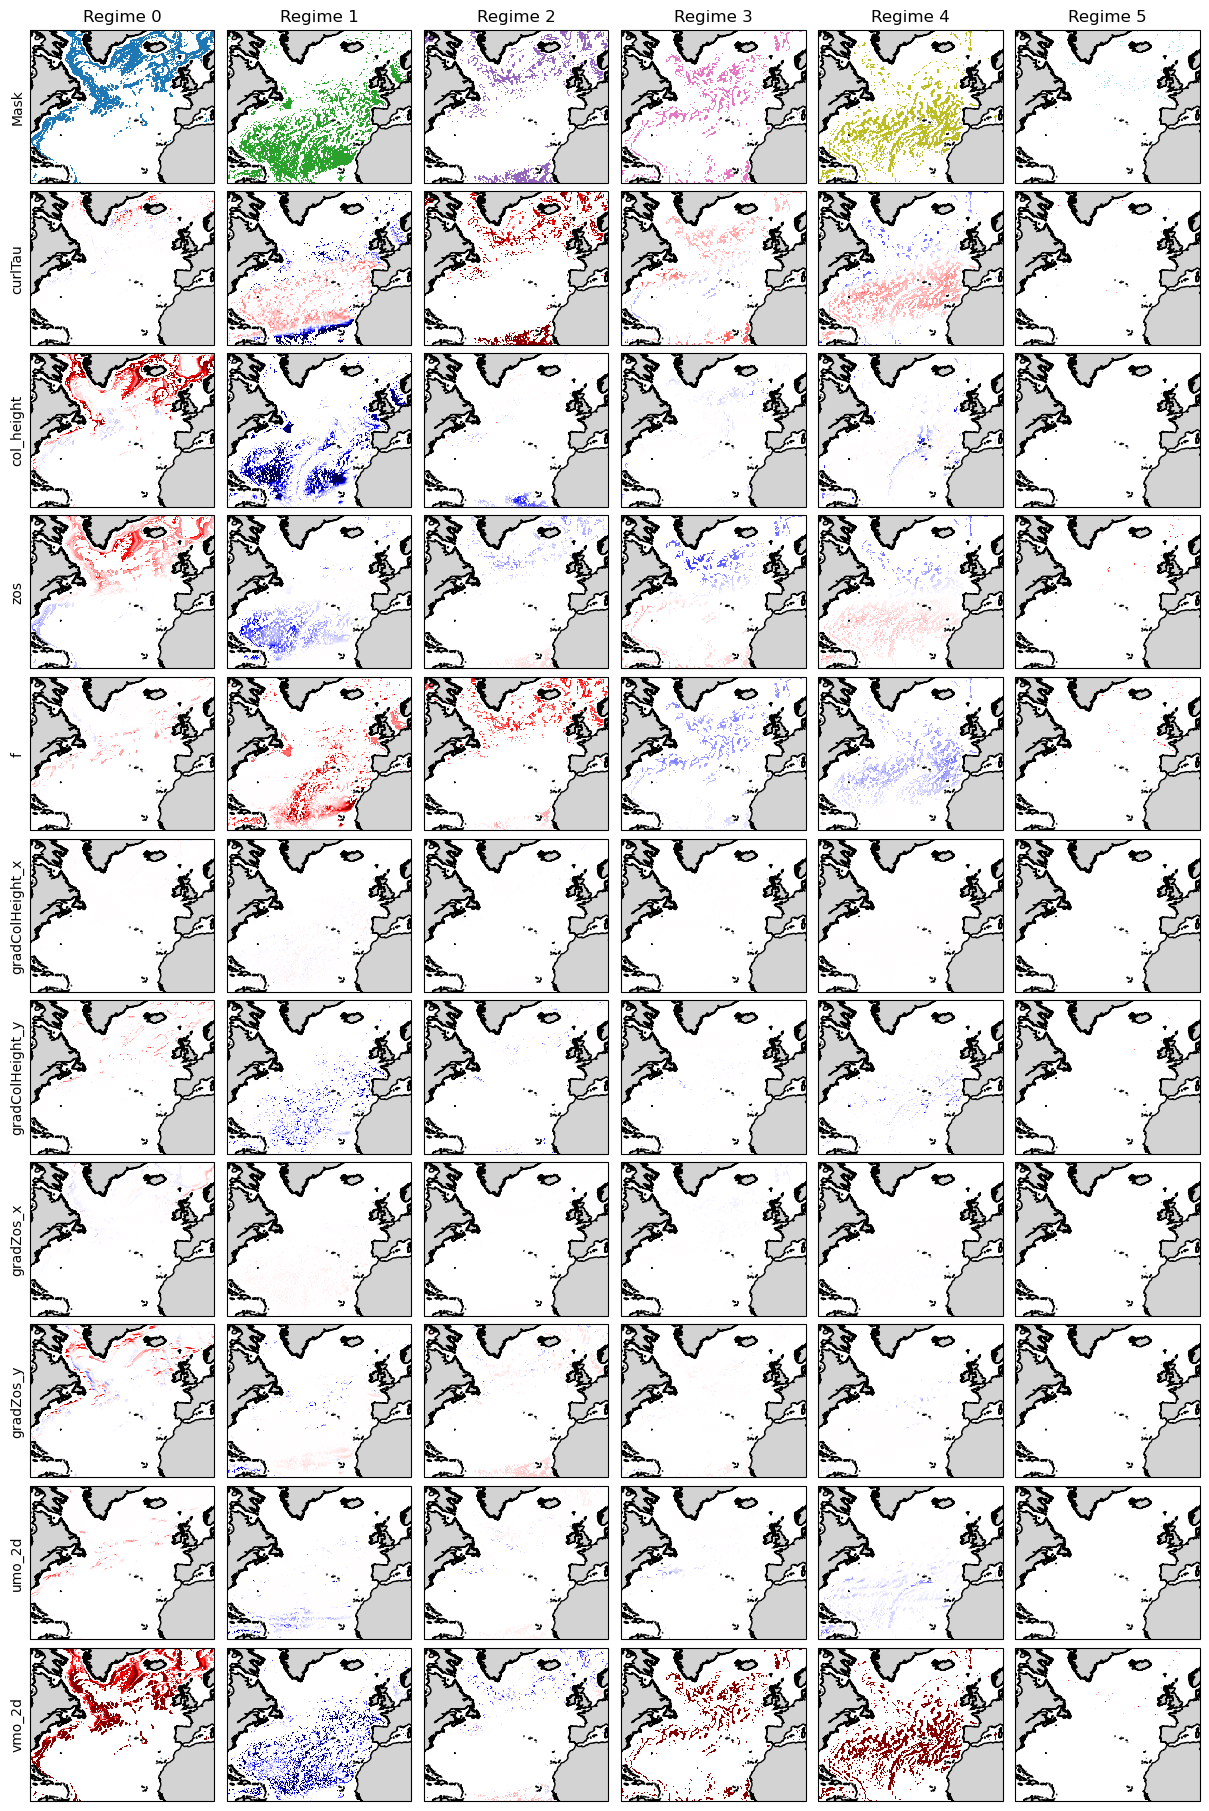

In [14]:
if experiment == 'control':
    lrp_plot_by_regime(save_path=f'figures/lrp/lrp_by_regime_natlantic_{experiment}.png')
else:
    lrp_plot_by_regime_scenario(save_path=f'figures/lrp/lrp_by_regime_natlantic_{experiment}.png')

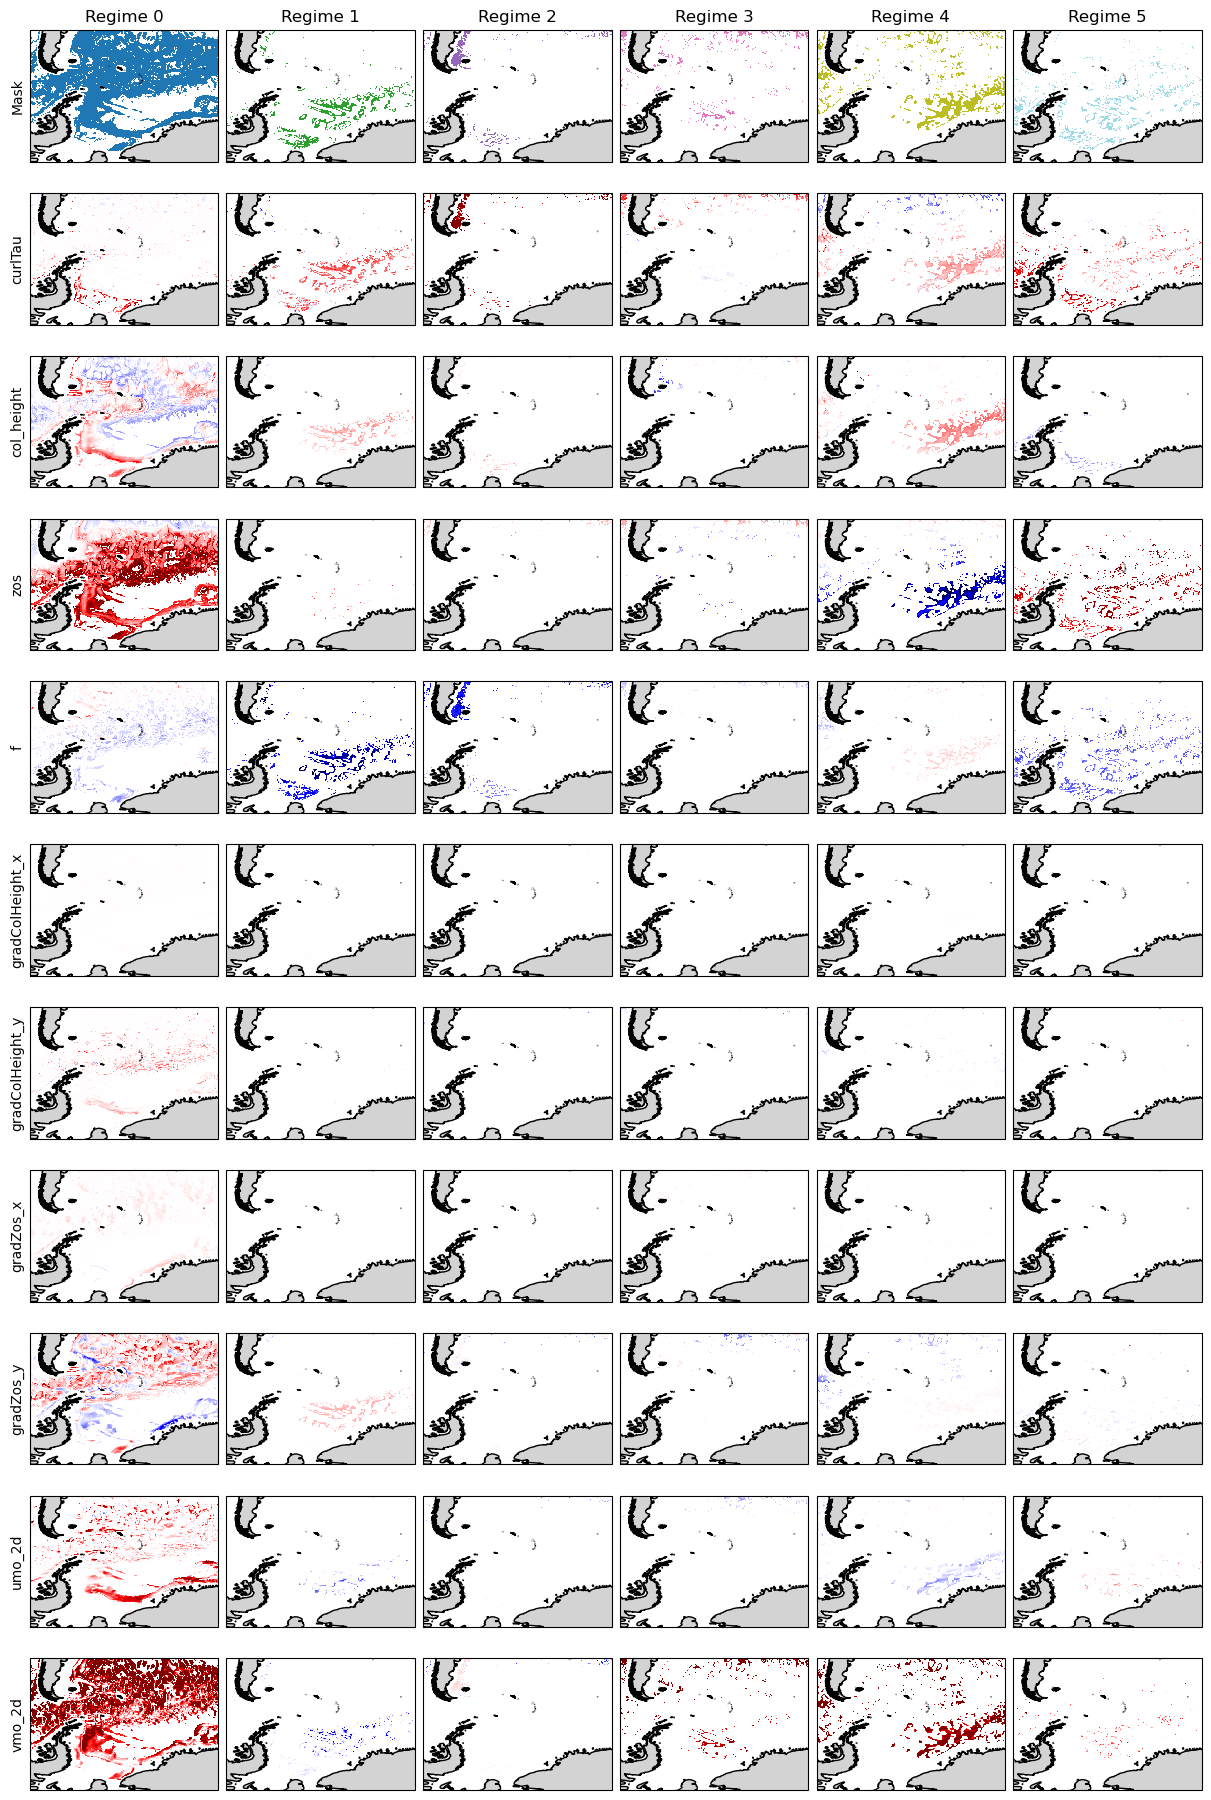

In [15]:
if experiment == 'control':
    lrp_plot_by_regime_socean(save_path=f'figures/lrp/lrp_by_regime_socean_{experiment}.png')
else:
    lrp_plot_by_regime_socean_scenario(save_path=f'figures/lrp/lrp_by_regime_socean_{experiment}.png')

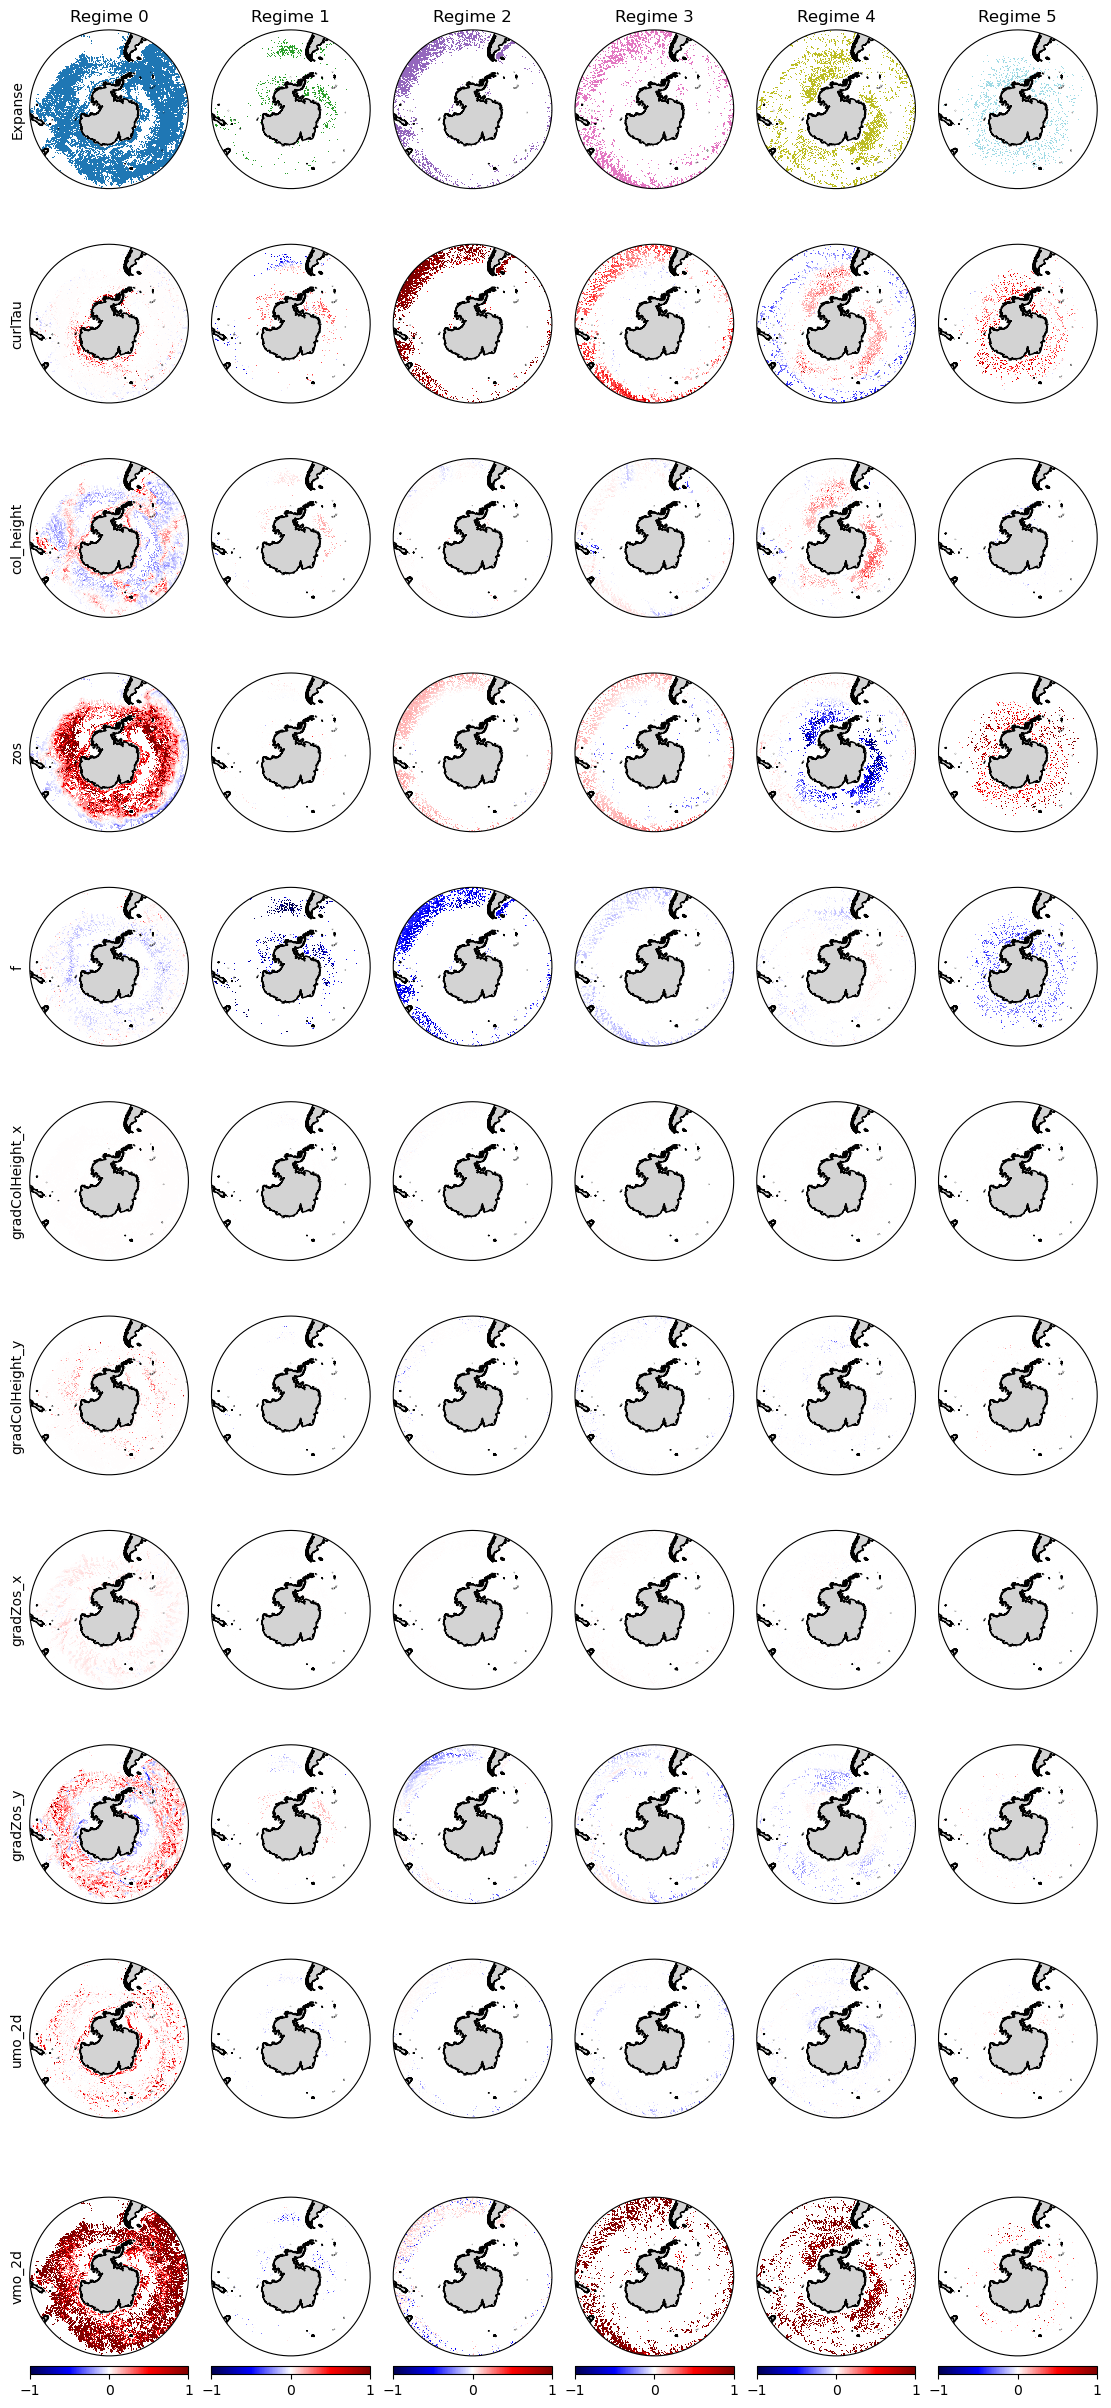

In [20]:
if experiment == 'control':
    lrp_plot_by_regime_socean_full(save_path=f'figures/lrp/lrp_by_regime_socean_full_{experiment}.png')
else:
    #lrp_plot_by_regime_socean_full_scenario(save_path=f'figures/lrp/lrp_by_regime_socean_full_{experiment}.png')
    lrp_plot_by_regime_socean_full_scenario(save_path=f'figures/neurips/lrp_by_regime_socean_full_{experiment}.png')

In [19]:
def lrp_plot_by_regime_socean_full_scenario_first_half(save_path=None):
    fig, axes = plt.subplots(6, num_clusters, subplot_kw={'projection':ccrs.SouthPolarStereo(central_longitude=-90)}, figsize=(11,12), constrained_layout=True)
    
    for regime in range(num_clusters):
        # Plot the isolated regime
        regime_mask = xr.where(total_pred == regime, total_pred, np.nan)
        to_plot = regime_mask.sel(lat=slice(-90,-40))
        to_plot.plot(ax=axes[0,regime], transform=ccrs.PlateCarree(),
                     cmap=ListedColormap(plt.get_cmap('tab20', num_clusters).colors[regime]),
                     add_colorbar=False, vmin=0, vmax=1)
        axes[0,regime].set_title(f'Regime {regime}')
    
    for var_idx in range(5):
        
        # Get the LRP values for an input variable
        ensemble = LRP_ensemble_scaled[:,:,var_idx]
    
        ds_25 = np.zeros((sizeflat[0]*sizeflat[1]))
        ds_25[~missingdataindex.flatten()] = np.percentile(ensemble, 25, axis=0)

        ds_75 = np.zeros((sizeflat[0]*sizeflat[1]))
        ds_75[~missingdataindex.flatten()] = np.percentile(ensemble, 75, axis=0)

        LRP_consist_full = np.zeros((sizeflat[0]*sizeflat[1]))
        LRP_consist_full[ds_75 < 0] = ds_75[ds_75 < 0]
        LRP_consist_full[ds_25 > 0] = ds_25[ds_25 > 0]
        LRP_consist_full = LRP_consist_full.reshape(sizeflat)
        LRP_consist_full = xr.DataArray(data=LRP_consist_full,
                                        dims=['lat','lon'],
                                        coords=dict(lat=col_height['lat'], lon=col_height['lon']),
                                        name='LRP')
            
        for regime in range(num_clusters):
            
            # Plot the LRP values for the regime
            LRP_consist_full_masked = xr.where(total_pred == regime, LRP_consist_full, np.nan)
            to_plot = LRP_consist_full_masked.sel(lat=slice(-90,-40))
            
            if var_idx == 4:
                to_plot.plot(ax=axes[var_idx+1,regime], transform=ccrs.PlateCarree(), cmap='seismic',
                             add_colorbar=True, vmin=-1, vmax=1, cbar_kwargs={'label':'', 'orientation':'horizontal'})
            else:
                to_plot.plot(ax=axes[var_idx+1,regime], transform=ccrs.PlateCarree(), cmap='seismic',
                             add_colorbar=False, vmin=-1, vmax=1)
            
    axes[0,0].set_ylabel('Expanse')
    
    #feature_names = ['curlTau', 'col_height', 'zos', 'f', 'gradColHeight_x',
    #                 'gradColHeight_y', 'gradZos_x', 'gradZos_y', 'umo_2d', 'vmo_2d']
    
    feature_names = ['curlTau', 'col_height', 'zos', 'f', 'gradColHeight_x']
    
    for i in range(len(feature_names)):
        axes[i+1,0].set_ylabel(feature_names[i])
        
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    for i in range(6):
        for j in range(num_clusters):
            axes[i,j].set_yticks([])
            if j != 0:
                axes[i,j].set_ylabel('')
            axes[i,j].add_feature(cfeature.LAND, facecolor='lightgrey')
            axes[i,j].coastlines(resolution='10m')
            axes[i,j].set_boundary(circle, transform=axes[i,j].transAxes)
            
    if save_path != None:
        plt.savefig(save_path, dpi=600)
    plt.show()
    
def lrp_plot_by_regime_socean_full_scenario_second_half(save_path=None):
    fig, axes = plt.subplots(6, num_clusters, subplot_kw={'projection':ccrs.SouthPolarStereo(central_longitude=-90)}, figsize=(11,12), constrained_layout=True)
    
    for regime in range(num_clusters):
        # Plot the isolated regime
        regime_mask = xr.where(total_pred == regime, total_pred, np.nan)
        to_plot = regime_mask.sel(lat=slice(-90,-40))
        to_plot.plot(ax=axes[0,regime], transform=ccrs.PlateCarree(),
                     cmap=ListedColormap(plt.get_cmap('tab20', num_clusters).colors[regime]),
                     add_colorbar=False, vmin=0, vmax=1)
        axes[0,regime].set_title(f'Regime {regime}')
    
    for var_idx in range(5):
        
        # Get the LRP values for an input variable
        ensemble = LRP_ensemble_scaled[:,:,var_idx+5]
    
        ds_25 = np.zeros((sizeflat[0]*sizeflat[1]))
        ds_25[~missingdataindex.flatten()] = np.percentile(ensemble, 25, axis=0)

        ds_75 = np.zeros((sizeflat[0]*sizeflat[1]))
        ds_75[~missingdataindex.flatten()] = np.percentile(ensemble, 75, axis=0)

        LRP_consist_full = np.zeros((sizeflat[0]*sizeflat[1]))
        LRP_consist_full[ds_75 < 0] = ds_75[ds_75 < 0]
        LRP_consist_full[ds_25 > 0] = ds_25[ds_25 > 0]
        LRP_consist_full = LRP_consist_full.reshape(sizeflat)
        LRP_consist_full = xr.DataArray(data=LRP_consist_full,
                                        dims=['lat','lon'],
                                        coords=dict(lat=col_height['lat'], lon=col_height['lon']),
                                        name='LRP')
            
        for regime in range(num_clusters):
            
            # Plot the LRP values for the regime
            LRP_consist_full_masked = xr.where(total_pred == regime, LRP_consist_full, np.nan)
            to_plot = LRP_consist_full_masked.sel(lat=slice(-90,-40))
            
            if var_idx == 4:
                to_plot.plot(ax=axes[var_idx+1,regime], transform=ccrs.PlateCarree(), cmap='seismic',
                             add_colorbar=True, vmin=-1, vmax=1, cbar_kwargs={'label':'', 'orientation':'horizontal'})
            else:
                to_plot.plot(ax=axes[var_idx+1,regime], transform=ccrs.PlateCarree(), cmap='seismic',
                             add_colorbar=False, vmin=-1, vmax=1)
            
    axes[0,0].set_ylabel('Expanse')
    
    #feature_names = ['curlTau', 'col_height', 'zos', 'f', 'gradColHeight_x',
    #                 'gradColHeight_y', 'gradZos_x', 'gradZos_y', 'umo_2d', 'vmo_2d']
    
    feature_names = ['gradColHeight_y', 'gradZos_x', 'gradZos_y', 'umo_2d', 'vmo_2d']
    
    for i in range(len(feature_names)):
        axes[i+1,0].set_ylabel(feature_names[i])
        
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    for i in range(6):
        for j in range(num_clusters):
            axes[i,j].set_yticks([])
            if j != 0:
                axes[i,j].set_ylabel('')
            axes[i,j].add_feature(cfeature.LAND, facecolor='lightgrey')
            axes[i,j].coastlines(resolution='10m')
            axes[i,j].set_boundary(circle, transform=axes[i,j].transAxes)
            
    if save_path != None:
        plt.savefig(save_path, dpi=600)
    plt.show()

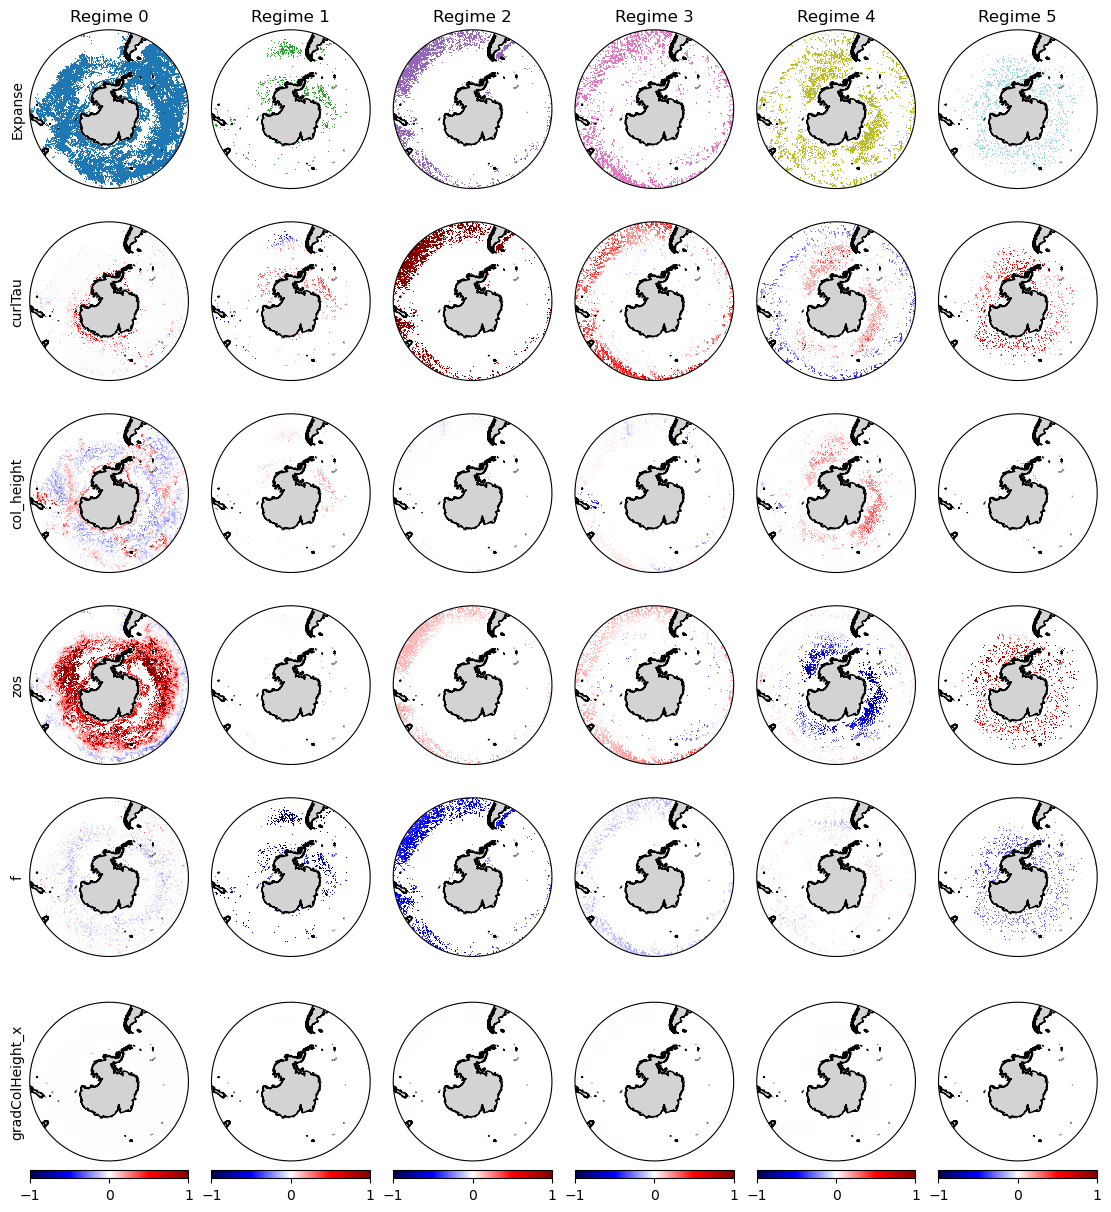

In [18]:
lrp_plot_by_regime_socean_full_scenario_first_half(
    save_path=f'figures/neurips/lrp_by_regime_socean_full_{experiment}_first_half.png')

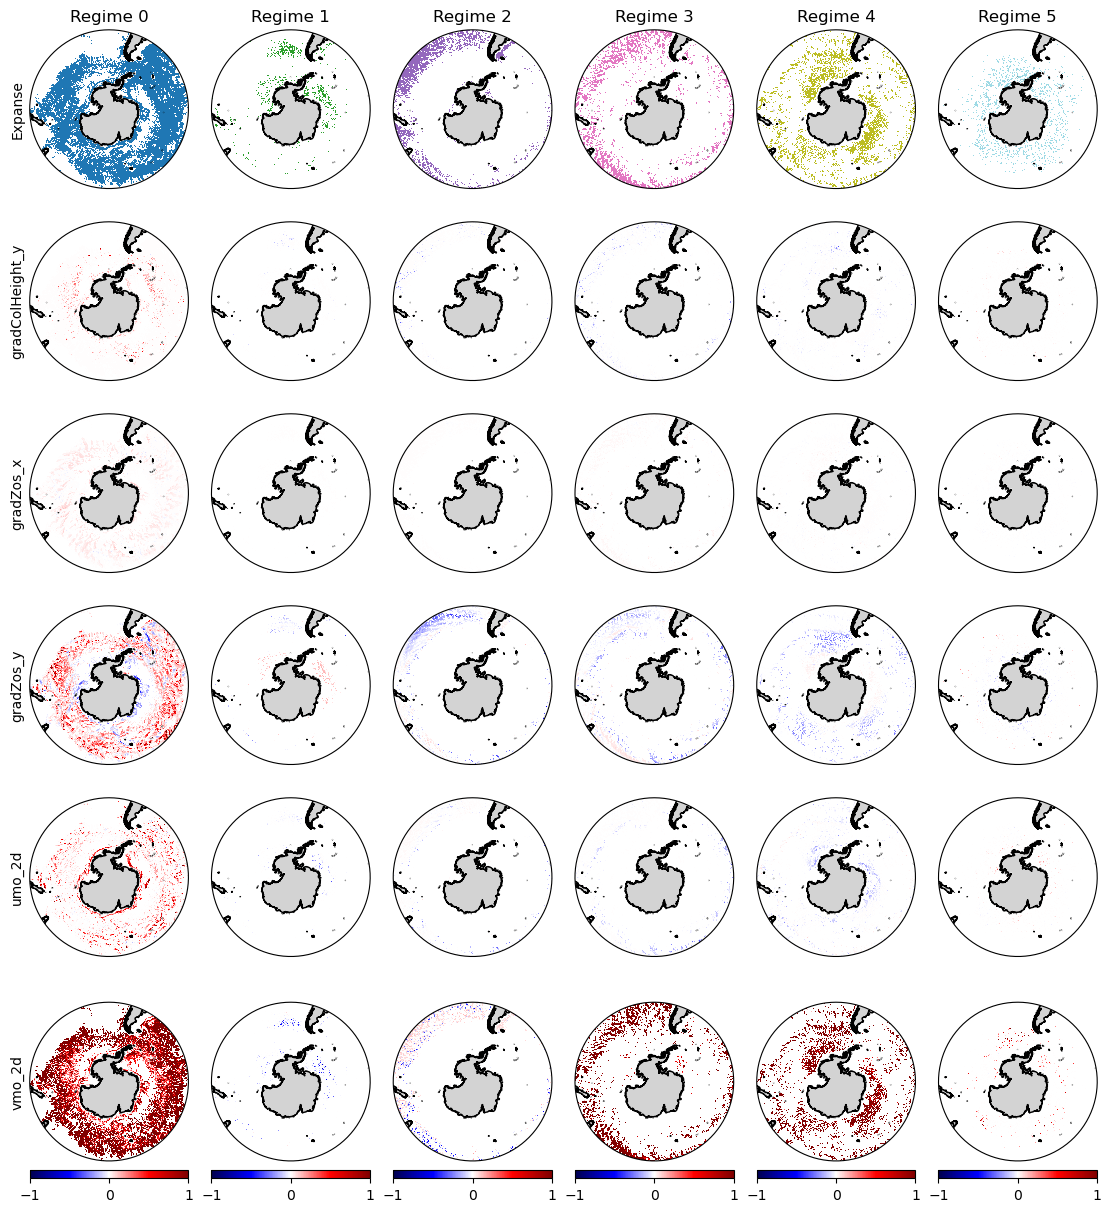

In [20]:
lrp_plot_by_regime_socean_full_scenario_second_half(
    save_path=f'figures/neurips/lrp_by_regime_socean_full_{experiment}_second_half.png')